In [ ]:
### This notebook implements the use of ML to predict thresholds and uses the pipeline created in the other notebook

In [1]:
#pip install big-fish

import os
import bigfish
import bigfish.stack as stack
import bigfish.plot as plot
import bigfish.detection as detection
import bigfish.segmentation as segmentation
import bigfish.multistack as multistack
import bigfish.classification as classification

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as s
from scipy import stats
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import mannwhitneyu


print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


/Users/bilalsyed/opt/anaconda3/lib/python3.9/site-packages/bigfish/segmentation/nuc_segmentation.py:16: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


# Machine Learning to Predict the Threshold

### Create the dataset -- set segmentation threshold manually for each image

In [2]:
### This is what I will feed into the ML model. Using this function to create the dataset. Image details along with their threshold. Can be used for dapi as well as rna

def get_image_details(pic, n):
    l = []
    l.append(pic.min())
    l.append(pic.max())
    l.append(pic.std())
    l.append(pic.mean())
    l.append(s.mode(pic.ravel()))
    l.append(np.quantile(pic,0.25))
    l.append(np.quantile(pic,0.50))
    l.append(np.quantile(pic,0.75))
    l.append(n)
    return l

In [3]:
path_input = "/Users/bilalsyed/FISH/input"
folders = os.listdir(path_input)
folders.sort()
folders = folders[1:-1]
print(folders)

# Select folder
folder = folders[15]
print("\n\n"+folder)

files = os.listdir(os.path.join(path_input, folder, "dv"))
files.sort()
# files = files[1:len(files)]    #.DS_Store
files

['BY_Atp4-GFP_20april', 'BY_Atp4-GFP_30June', 'BY_Atp4-GFP_30May', 'BY_Atp4-GFP_31May', 'BY_Gcv3-GFP_20april', 'BY_Gcv3-GFP_30June', 'BY_Gcv3-GFP_30May02', 'BY_Gcv3-GFP_31May', 'BY_Gcv3-GFP_31May12', 'BY_Hms2-GFP_10May07', 'BY_Hms2-GFP_22May07', 'BY_Tim17-GFP_06July', 'BY_Tim17-GFP_22april', 'BY_Tim17-GFP_31May', 'BY_Ura4-GFP_06July', 'BY_Ura4-GFP_22april']


BY_Ura4-GFP_22april


['BY_Ura4-GFP_GFPprobe_MW_20april03_01_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_02_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_03_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_04_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_05_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_06_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_07_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_08_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_09_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_10_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_11_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_12_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_13_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_14_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_15_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_16_R3D.dv',
 'BY_Ura4-GFP_GFPprobe_MW_20april03_17_R3D.dv']

In [4]:
# Getting all the files from the set

rna = []
dapi = []
for f in files:
    path_dapi = os.path.join(path_input, folder, "dv", f)
    dv = stack.read_dv(path_dapi)
    rna.append(dv[:,0,:,:])
    dapi.append(dv[:,1,:,:])

print(len(rna))

17


In [ ]:
### Created an empty list. Commented because if I ran it by mistake I would lose all data and have to start over

# dapi_data = []
# rna_data = []

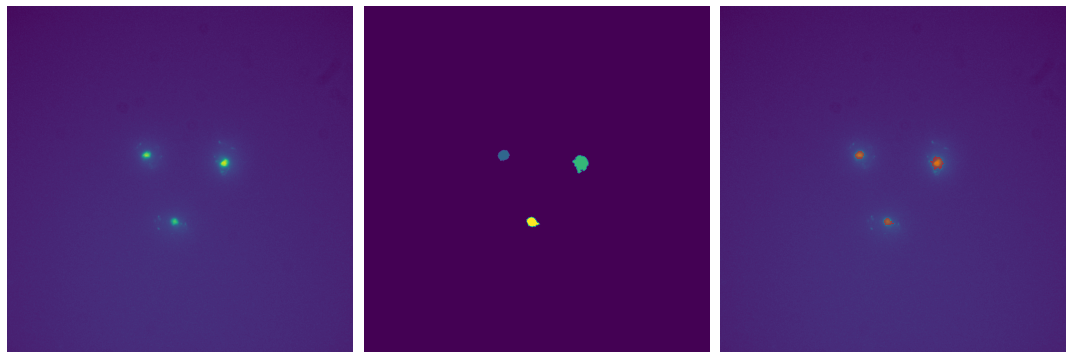

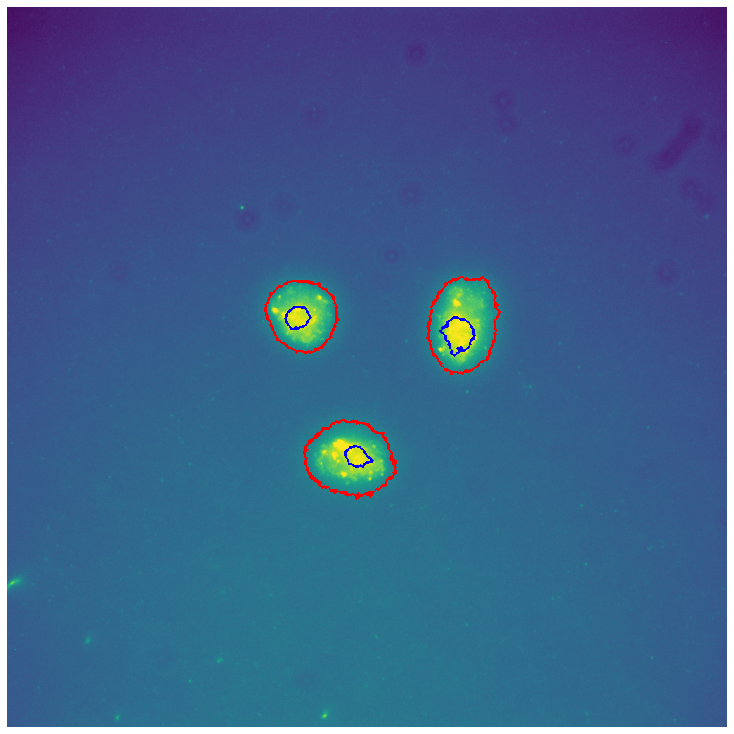

In [5]:
i = 1       # Change this, to select a different file
dapi_t = 4  # Change this, to change the n in n*std [for dapi]
nuc_t = 1   # Change this, to change the n in n*std [for rna]

nuc_2d = stack.maximum_projection(dapi[i])
rna_2d = stack.maximum_projection(rna[i])

# thresholding
t_nuc = s.mode(nuc_2d.ravel()) + dapi_t*np.std(nuc_2d)
nuc_mask = segmentation.thresholding(nuc_2d, threshold=int(t_nuc))
nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=300, fill_holes=True)

# labeling
nuc_label = segmentation.label_instances(nuc_mask)

# apply watershed
t_rna = s.mode(rna_2d.ravel()) + nuc_t*np.std(rna_2d)
cell_label = segmentation.cell_watershed(rna_2d, nuc_label, threshold=int(t_rna), alpha=0.9)


plot.plot_segmentation(nuc_2d, nuc_label, rescale=True)
plot.plot_segmentation_boundary(rna_2d, cell_label, nuc_label, contrast=True, boundary_size=2)

In [ ]:
### When satisfied with the segmentation, append the image details and the chosen threshold

dapi_data.append(get_image_details(nuc_2d,dapi_t))
rna_data.append(get_image_details(rna_2d,nuc_t))

In [ ]:
### After done with all the files, save the data as an np array

np.save("/Users/bilalsyed/FISH/rna_data", rna_data)
np.save("/Users/bilalsyed/FISH/dapi_data", dapi_data)

In [6]:
rna_data = np.load("/Users/bilalsyed/FISH/rna_data.npy")
rna_data_df = pd.DataFrame(rna_data)
rna_data_df.rename(
    columns={0: "Min", 1: "Max", 2: "Std", 3: "Avg", 4: "Mode", 5: "25%", 6: "50%", 7: "75%", 8: "Threshold"},
    inplace=True,
)

rna_data_df

,Min,Max,Std,Avg,Mode,25%,50%,75%,Threshold
0,530.0,1893.0,75.898905,722.905335,750.0,683.0,718.0,747.0,0.3
1,500.0,1465.0,44.768501,664.341290,696.0,638.0,666.0,690.0,1.5
2,516.0,1493.0,63.163893,692.992995,688.0,659.0,689.0,714.0,0.8
3,542.0,3503.0,55.753295,718.509244,745.0,686.0,722.0,746.0,0.6
4,561.0,3505.0,62.720149,776.693500,795.0,744.0,775.0,800.0,1.0
...,...,...,...,...,...,...,...,...,...
210,424.0,1212.0,48.487545,574.987265,604.0,545.0,575.0,602.0,0.3
211,425.0,1442.0,57.132555,613.119400,654.0,575.0,615.0,648.0,0.1
212,364.0,1272.0,52.518430,512.076435,539.0,480.0,510.0,536.0,0.4
213,325.0,1170.0,43.195421,453.987722,472.0,426.0,456.0,477.0,0.5


In [8]:
dapi_data = np.load("/Users/bilalsyed/FISH/dapi_data.npy")
dapi_data_df = pd.DataFrame(dapi_data)
dapi_data_df.rename(
    columns={0: "Min", 1: "Max", 2: "Std", 3: "Avg", 4: "Mode", 5: "25%", 6: "50%", 7: "75%", 8: "Threshold"},
    inplace=True,
)

dapi_data_df

,Min,Max,Std,Avg,Mode,25%,50%,75%,Threshold
0,172.0,502.0,13.808823,199.576050,200.0,193.0,199.0,203.0,5.0
1,163.0,363.0,7.356586,186.542775,187.0,183.0,186.0,190.0,8.0
2,168.0,469.0,12.386270,195.049159,195.0,189.0,194.0,199.0,4.5
3,173.0,422.0,9.975201,200.854001,202.0,196.0,201.0,205.0,6.0
4,184.0,586.0,13.711908,214.001166,215.0,208.0,213.0,218.0,6.5
...,...,...,...,...,...,...,...,...,...
210,146.0,335.0,6.240414,167.471588,170.0,163.0,168.0,171.0,4.0
211,150.0,253.0,6.854926,175.068378,178.0,170.0,175.0,180.0,3.0
212,141.0,261.0,6.407214,159.605617,161.0,155.0,160.0,163.0,4.0
213,137.0,286.0,6.099303,155.329844,156.0,152.0,155.0,159.0,5.0


In [ ]:
dapi_data_df.to_csv("/Users/bilalsyed/FISH/dapi_data_df.csv")
rna_data_df.to_csv("/Users/bilalsyed/FISH/rna_data_df.csv")

### Briefly analyse the dataset

In [9]:
dapi_df = pd.read_csv("/Users/bilalsyed/FISH/dapi_data_df.csv")
dapi_df = dapi_df.drop(dapi_df.columns[0], axis=1)
rna_df = pd.read_csv("/Users/bilalsyed/FISH/rna_data_df.csv")
rna_df = rna_df.drop(rna_df.columns[0], axis=1)

dapi_df["T_Value"] = dapi_df["Mode"] + dapi_df["Threshold"]*dapi_df["Std"]
rna_df["T_Value"] = rna_df["Mode"] + rna_df["Threshold"]*rna_df["Std"]

dapi_df.drop("Threshold", axis=1, inplace=True)
rna_df.drop("Threshold", axis=1, inplace=True)

orig_dapi = dapi_df.copy()
orig_rna = rna_df.copy()

dapi_df["Min/Max"] = dapi_df["Min"]/dapi_df["Max"]
rna_df["Min/Max"] = rna_df["Min"]/rna_df["Max"]

dapi_df["Std/Mode"] = dapi_df["Std"]/dapi_df["Mode"]
rna_df["Std/Mode"] = rna_df["Std"]/rna_df["Mode"]

dapi_df["Std/Avg"] = dapi_df["Std"]/dapi_df["Avg"]
rna_df["Std/Avg"] = rna_df["Std"]/rna_df["Avg"]

In [10]:
dapi_df.head()

,Min,Max,Std,Avg,Mode,25%,50%,75%,T_Value,Min/Max,Std/Mode,Std/Avg
0,172,502,13.808823,199.576050,200,193.0,199.0,203.0,269.044113,0.342629,0.069044,0.069191
1,163,363,7.356586,186.542775,187,183.0,186.0,190.0,245.852690,0.449036,0.039340,0.039436
2,168,469,12.386270,195.049159,195,189.0,194.0,199.0,250.738217,0.358209,0.063519,0.063503
3,173,422,9.975201,200.854001,202,196.0,201.0,205.0,261.851205,0.409953,0.049382,0.049664
4,184,586,13.711908,214.001166,215,208.0,213.0,218.0,304.127405,0.313993,0.063776,0.064074


In [11]:
rna_df.head()

,Min,Max,Std,Avg,Mode,25%,50%,75%,T_Value,Min/Max,Std/Mode,Std/Avg
0,530,1893,75.898905,722.905335,750,683.0,718.0,747.0,772.769672,0.279979,0.101199,0.104991
1,500,1465,44.768501,664.341290,696,638.0,666.0,690.0,763.152751,0.341297,0.064323,0.067388
2,516,1493,63.163893,692.992995,688,659.0,689.0,714.0,738.531115,0.345613,0.091808,0.091147
3,542,3503,55.753295,718.509244,745,686.0,722.0,746.0,778.451977,0.154725,0.074837,0.077596
4,561,3505,62.720149,776.693500,795,744.0,775.0,800.0,857.720149,0.160057,0.078893,0.080753


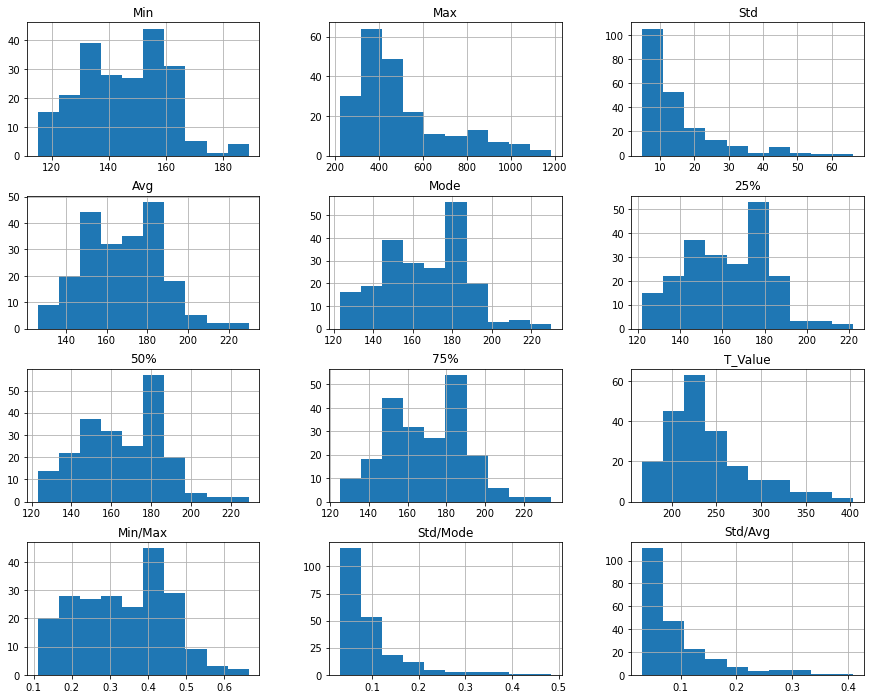

In [12]:
dapi_df.hist(bins=10, figsize=(15, 12))
plt.show()

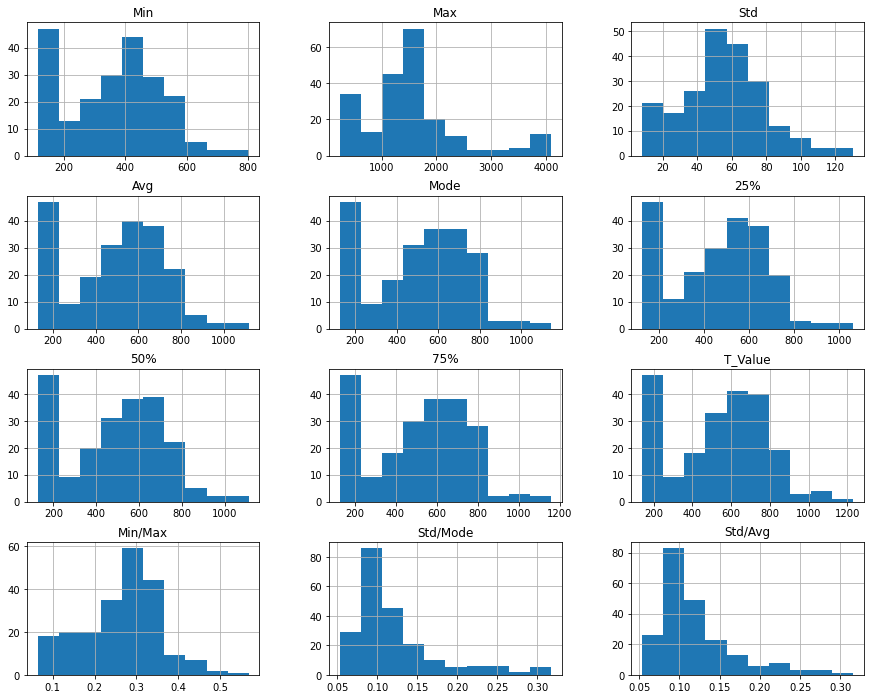

In [13]:
rna_df.hist(bins=10, figsize=(15, 12))
plt.show()

# Vertical line? Might wanna remove it for ML

In [14]:
dapi_df.corr()["T_Value"].sort_values(ascending=False)

# I was using Mode + Std. It apparently barely depends on mode...

T_Value     1.000000
Max         0.875431
Std         0.787404
Std/Avg     0.725013
Std/Mode    0.706708
Avg         0.248571
75%         0.169895
Min         0.153222
25%         0.136584
50%         0.136263
Mode        0.106590
Min/Max    -0.737054
Name: T_Value, dtype: float64

In [15]:
rna_df.corr()["T_Value"].sort_values(ascending=False)

# But here it heavily depends on mode. But the vertical lines must be messing with the data... Does it matter though?
# That's just representing what the image has. That is what the user will give. So our model SHOULD use that data. Hmm...

T_Value     1.000000
Mode        0.997078
50%         0.996896
25%         0.996826
Avg         0.996599
75%         0.996444
Min         0.994675
Std         0.733024
Max         0.523099
Min/Max     0.129760
Std/Avg    -0.349192
Std/Mode   -0.381851
Name: T_Value, dtype: float64

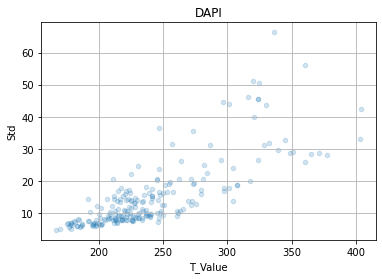

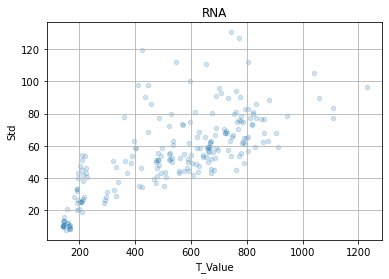

In [16]:
dapi_df.plot(kind="scatter", x="T_Value", y="Std", grid=True, alpha=0.2, title="DAPI")
plt.show()
rna_df.plot(kind="scatter", x="T_Value", y="Std", grid=True, alpha=0.2, title="RNA")
plt.show()

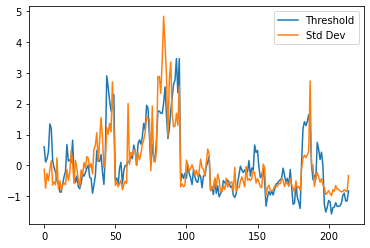

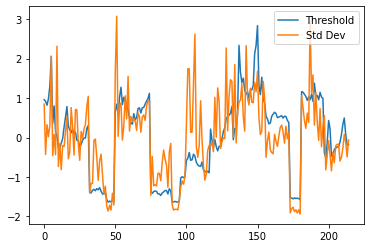

In [17]:
std_scaler = StandardScaler()

plt.plot(std_scaler.fit_transform(dapi_df[["T_Value","Std"]])[:,0], label='Threshold')
plt.plot(std_scaler.fit_transform(dapi_df[["T_Value","Std"]])[:,1], label='Std Dev')
plt.legend()
plt.show()

plt.plot(std_scaler.fit_transform(rna_df[["T_Value","Std"]])[:,0], label='Threshold')
plt.plot(std_scaler.fit_transform(rna_df[["T_Value","Std"]])[:,1], label='Std Dev')
plt.legend()
plt.show()

### Preparing the Data for ML


In [18]:
# Revert to original df

dapi_df = orig_dapi
rna_df = orig_rna

# Separate train/test set

train_dapi, test_dapi = train_test_split(dapi_df, test_size=0.2, random_state=42)
train_rna, test_rna = train_test_split(rna_df, test_size=0.2, random_state=42)

# Separate predictors and labels

dapi = train_dapi.drop("T_Value", axis=1)
dapi_labels = train_dapi["T_Value"].copy()

rna = train_rna.drop("T_Value", axis=1)
rna_labels = train_rna["T_Value"].copy()

dapi.head()

,Min,Max,Std,Avg,Mode,25%,50%,75%
93,139,1053,33.006747,161.783921,156,154.0,157.0,161.0
84,126,1051,66.311462,161.868163,137,136.0,139.0,154.0
95,136,1150,42.438415,158.434723,149,147.0,150.0,154.0
137,165,335,7.492570,191.541816,193,187.0,192.0,196.0
210,146,335,6.240414,167.471588,170,163.0,168.0,171.0


## DAPI ML

### Linear Regression

In [19]:
dapi.info()              # No missing

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 93 to 102
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Min     172 non-null    int64  
 1   Max     172 non-null    int64  
 2   Std     172 non-null    float64
 3   Avg     172 non-null    float64
 4   Mode    172 non-null    int64  
 5   25%     172 non-null    float64
 6   50%     172 non-null    float64
 7   75%     172 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 12.1 KB


In [20]:
### Basic model

lin_reg = LinearRegression()
lin_reg.fit(dapi, dapi_labels)

lin_rmses = -cross_val_score(lin_reg, dapi, dapi_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    10.000000
mean     14.559676
std       3.645051
min       9.824649
25%      12.914442
50%      13.344238
75%      15.277692
max      23.315995
dtype: float64

### Trying to improve the model

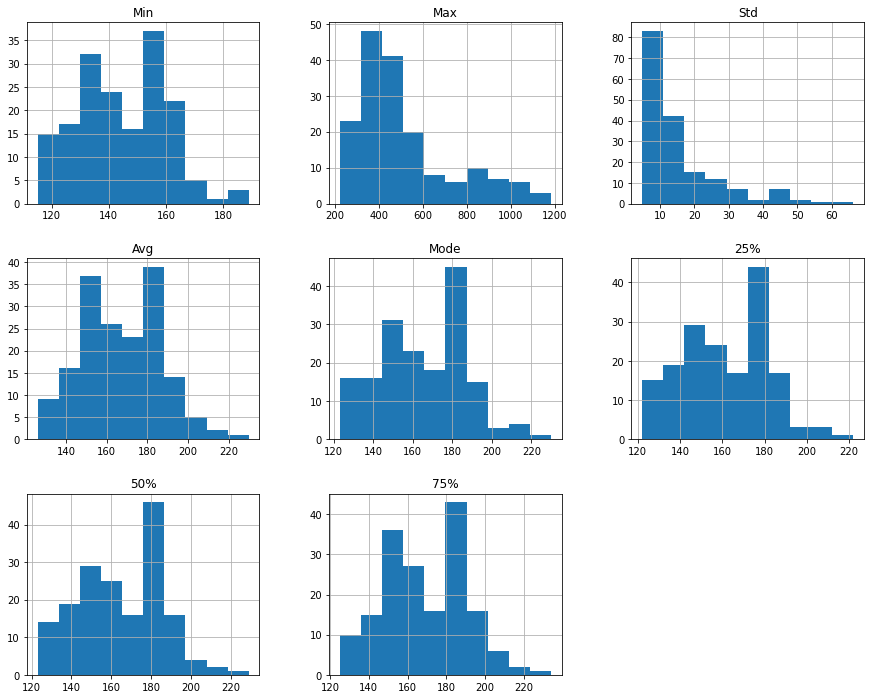

In [21]:
dapi.hist(bins=10, figsize=(15, 12))
plt.show()

"it’s often a good idea to transform features with heavy-tailed distributions by replacing them with their logarithm (assuming the feature is positive and the tail is on the right)."

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 141). O'Reilly Media. Kindle Edition. 

In [22]:
def apply_log(df):
    log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
    df["log_max"] = log_transformer.transform(df[["Max"]])
    df["log_std"] = log_transformer.transform(df[["Std"]])
    return df

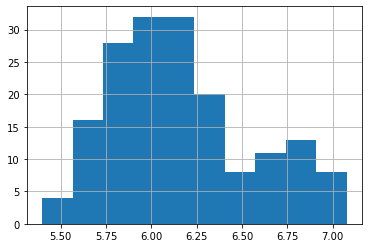

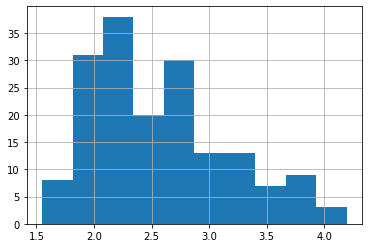

In [23]:
temp_dapi = apply_log(dapi)

temp_dapi["log_max"].hist()
plt.show()
temp_dapi["log_std"].hist()
plt.show()

In [24]:
### As we saw earlier calculating certain ratios is giving higher correlation to the threshold. So,

def ratio(df):
    df["Min/Max"] = df["Min"]/df["Max"]
    df["Std/Mode"] = df["Std"]/df["Mode"]
    df["Std/Avg"] = df["Std"]/df["Avg"]
    return df

In [25]:
temp_dapi = ratio(dapi)
temp_dapi.head()

,Min,Max,Std,Avg,Mode,25%,50%,75%,log_max,log_std,Min/Max,Std/Mode,Std/Avg
93,139,1053,33.006747,161.783921,156,154.0,157.0,161.0,6.959399,3.496712,0.132004,0.211582,0.204017
84,126,1051,66.311462,161.868163,137,136.0,139.0,154.0,6.957497,4.194363,0.119886,0.484025,0.409663
95,136,1150,42.438415,158.434723,149,147.0,150.0,154.0,7.047517,3.748054,0.118261,0.284822,0.267861
137,165,335,7.492570,191.541816,193,187.0,192.0,196.0,5.814131,2.013912,0.492537,0.038822,0.039117
210,146,335,6.240414,167.471588,170,163.0,168.0,171.0,5.814131,1.831046,0.435821,0.036708,0.037263


"With few exceptions, machine learning algorithms don’t perform well when the input numerical attributes have very different scales."

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 134). O'Reilly Media. Kindle Edition. 

In [26]:
### Scale

def scale(df):
    std_scaler = StandardScaler()
    df_scaled = std_scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns)
    return df

In [27]:
temp_dapi = scale(dapi)
temp_dapi.head()

,Min,Max,Std,Avg,Mode,25%,50%,75%,log_max,log_std,Min/Max,Std/Mode,Std/Avg
0,-0.380522,2.452238,1.505737,-0.269571,-0.430605,-0.344156,-0.371958,-0.370800,2.057315,1.576431,-1.607490,1.354709,1.466396
1,-1.233930,2.443157,4.432081,-0.265283,-1.313980,-1.252516,-1.238461,-0.702914,2.052421,2.766616,-1.706035,4.688025,4.291366
2,-0.577462,2.892666,2.334458,-0.440034,-0.756059,-0.697407,-0.708931,-0.702914,2.284178,2.005218,-1.719249,2.250790,2.343412
3,1.326293,-0.807839,-0.736085,1.245011,1.289652,1.321171,1.312908,1.289767,-0.891187,-0.953209,1.324395,-0.758991,-0.798851
4,0.079005,-0.807839,-0.846107,0.019913,0.220303,0.110024,0.157571,0.103648,-0.891187,-1.265175,0.863173,-0.784847,-0.824328


### Test Performance

In [31]:
def get_cv_score_LR(df, labels):
    lin_reg = LinearRegression()
    lin_reg.fit(df, labels)
    lin_rmses = -cross_val_score(lin_reg, df, labels, scoring="neg_root_mean_squared_error", cv=10)
    return pd.Series(lin_rmses).describe()

In [32]:
def test_performance(df, labels, fn):
    print("Basic\n")
    print(fn(df, labels))
    
    print("\nLog\n")
    temp = df.copy()
    temp = apply_log(temp)
    print(fn(temp, labels))
    
    print("\nRatio\n")
    temp = df.copy()
    temp = ratio(temp)
    print(fn(temp, labels))
    
    print("\nScale\n")
    temp = df.copy()
    temp = scale(temp)
    print(fn(temp, labels))
    
    print("\nLog + Scale\n")
    temp = df.copy()
    temp = apply_log(temp)
    temp = scale(temp)
    print(fn(temp, labels))
    
    print("\nLog + Ratio\n")
    temp = df.copy()
    temp = apply_log(temp)
    temp = ratio(temp)
    print(fn(temp, labels))
    
    print("\nRatio + Scale\n")
    temp = df.copy()
    temp = ratio(temp)
    temp = scale(temp)
    print(fn(temp, labels))
    
    print("\nLog + Ratio + Scale\n")
    temp = df.copy()
    temp = apply_log(temp)
    temp = ratio(temp)
    temp = scale(temp)
    print(fn(temp, labels))

In [33]:
dapi = train_dapi.drop("T_Value", axis=1)                    # Send the basic unadultered dataset
test_performance(dapi, dapi_labels, get_cv_score_LR)         # Basic is best [14.55/3.64]

Basic

count    10.000000
mean     14.559676
std       3.645051
min       9.824649
25%      12.914442
50%      13.344238
75%      15.277692
max      23.315995
dtype: float64

Log

count    10.000000
mean     14.551242
std       3.792201
min       9.485903
25%      12.429149
50%      13.630106
75%      16.261548
max      22.828728
dtype: float64

Ratio

count    10.000000
mean     15.193053
std       5.217097
min      10.994814
25%      12.353095
50%      13.143439
75%      16.395206
max      28.637295
dtype: float64

Scale

count    10.000000
mean     14.559676
std       3.645051
min       9.824649
25%      12.914442
50%      13.344238
75%      15.277692
max      23.315995
dtype: float64

Log + Scale

count    10.000000
mean     14.551242
std       3.792201
min       9.485903
25%      12.429149
50%      13.630106
75%      16.261548
max      22.828728
dtype: float64

Log + Ratio

count    10.000000
mean     15.165516
std       5.484981
min      10.587831
25%      11.950536
50%      13.1

### Random Forests

In [34]:
def get_cv_score_RF(df, labels):
    forest_reg = RandomForestRegressor(random_state=42)
    forest_reg.fit(df, labels)
    forest_rmses = -cross_val_score(forest_reg, df, labels, scoring="neg_root_mean_squared_error", cv=10)
    return pd.Series(forest_rmses).describe()

In [35]:
dapi = train_dapi.drop("T_Value", axis=1)
test_performance(dapi, dapi_labels, get_cv_score_RF)         # Log + Scale is the best, but barely [18.13/7.68]

Basic

count    10.000000
mean     18.164846
std       7.812906
min      11.435673
25%      13.270896
50%      16.126849
75%      18.567762
max      37.928974
dtype: float64

Log

count    10.000000
mean     18.177639
std       7.647717
min      11.398797
25%      13.237913
50%      16.514321
75%      18.704741
max      37.369839
dtype: float64

Ratio

count    10.000000
mean     18.876655
std       7.878341
min      11.909470
25%      13.592886
50%      17.408240
75%      18.985380
max      38.554866
dtype: float64

Scale

count    10.000000
mean     18.171564
std       7.866170
min      11.404485
25%      13.225314
50%      16.064313
75%      18.579021
max      37.965915
dtype: float64

Log + Scale

count    10.000000
mean     18.138723
std       7.682446
min      11.319347
25%      13.117127
50%      16.457286
75%      18.656932
max      37.380886
dtype: float64

Log + Ratio

count    10.000000
mean     18.736973
std       7.625383
min      11.790778
25%      14.070007
50%      17.0

### Using RandomizedSearchCV on Random Forests -- Hyperparameter Tuning

In [36]:
def rndS(df, labels):
    full_pipeline = Pipeline([
        ("random_forest", RandomForestRegressor(random_state=42)),
    ])

    param_distribs = {'random_forest__max_features': randint(low=2, high=20)}

    rnd_search = RandomizedSearchCV(
        full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
        scoring='neg_root_mean_squared_error', random_state=42)

    rnd_search.fit(df, labels)

    return rnd_search

In [37]:
def get_cv_score_RS(df, labels):
    
    rnd_search = rndS(df, labels)
    
    rnd_search.fit(df, labels)
    
    rnd_search_rsmes = -cross_val_score(rnd_search, df, labels, scoring="neg_root_mean_squared_error", cv=10)
    return pd.Series(rnd_search_rsmes).describe()

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
dapi = train_dapi.drop("T_Value", axis=1)
test_performance(dapi, dapi_labels, get_cv_score_RS)              # Scale is best [16.68/6.51]

Basic

count    10.000000
mean     16.692231
std       6.462793
min      12.103234
25%      12.350418
50%      15.482125
75%      16.476966
max      33.245474
dtype: float64

Log

count    10.000000
mean     17.271980
std       6.252693
min      12.059617
25%      13.065549
50%      15.629591
75%      17.698363
max      32.768211
dtype: float64

Ratio

count    10.000000
mean     17.219206
std       4.579113
min      13.197949
25%      14.189617
50%      15.789463
75%      18.058322
max      27.928459
dtype: float64

Scale

count    10.000000
mean     16.684966
std       6.512553
min      11.919496
25%      12.285272
50%      15.469617
75%      16.542124
max      33.293665
dtype: float64

Log + Scale

count    10.000000
mean     17.232183
std       6.315634
min      11.972374
25%      13.031256
50%      15.621724
75%      17.649927
max      32.818981
dtype: float64

Log + Ratio

count    10.000000
mean     17.492705
std       6.325694
min      11.765596
25%      13.910029
50%      15.2

In [40]:
rnd_search = rndS(dapi, dapi_labels)
best_model = rnd_search.best_estimator_
feature_importances = best_model["random_forest"].feature_importances_
feature_importances.round(2)
sorted(zip(feature_importances, dapi.columns), reverse=True)

# Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 168). O'Reilly Media. Kindle Edition. 

[(0.4492225215510657, 'Max'),
 (0.3623315828209494, 'Std'),
 (0.05541957254111054, 'Avg'),
 (0.03272672890678081, 'Min'),
 (0.02842140191495686, '50%'),
 (0.02818336949295895, 'Mode'),
 (0.024806819444225303, '25%'),
 (0.018888003327952454, '75%')]

Max and Std most important apparently. Mode is not.

In [41]:
lin_rmses = -cross_val_score(lin_reg, dapi[['Max','Std']], dapi_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    10.000000
mean     24.327292
std       7.008890
min      16.983816
25%      18.727812
50%      23.525096
75%      26.961754
max      39.940852
dtype: float64

In [42]:
forest_reg = RandomForestRegressor(random_state=42)
forest_rmses = -cross_val_score(forest_reg, dapi[['Max','Std']], dapi_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count    10.000000
mean     24.389121
std       6.388138
min      17.768694
25%      20.756323
50%      22.036764
75%      25.897967
max      39.205326
dtype: float64

### Final Model

In [43]:
dapi

,Min,Max,Std,Avg,Mode,25%,50%,75%
93,139,1053,33.006747,161.783921,156,154.0,157.0,161.0
84,126,1051,66.311462,161.868163,137,136.0,139.0,154.0
95,136,1150,42.438415,158.434723,149,147.0,150.0,154.0
137,165,335,7.492570,191.541816,193,187.0,192.0,196.0
210,146,335,6.240414,167.471588,170,163.0,168.0,171.0
...,...,...,...,...,...,...,...,...
106,133,446,11.867025,151.879575,152,147.0,151.0,154.0
14,148,437,9.149980,168.768128,169,165.0,168.0,171.0
92,140,1066,28.659572,159.782581,156,154.0,156.0,159.0
179,130,325,7.918593,145.501744,145,142.0,145.0,147.0


In [44]:
### Linear Regresion with Log is best

temp = dapi.copy()
temp = apply_log(temp)

dapi_model = LinearRegression()
dapi_model.fit(temp, dapi_labels)

LinearRegression()

## Evaluate on test set

In [52]:
X_test = test_dapi.drop("T_Value", axis=1)
apply_log(X_test)
y_test = test_dapi["T_Value"].copy()

final_predictions = dapi_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

12.052893067238823


## RNA ML

In [46]:
test_performance(rna, rna_labels, get_cv_score_LR)                # Log -- [15.56/4.98]

Basic

count    10.000000
mean     16.831347
std       4.921590
min      11.402878
25%      13.326745
50%      15.524447
75%      20.402190
max      24.920794
dtype: float64

Log

count    10.000000
mean     16.568626
std       4.984889
min      11.022171
25%      13.115061
50%      15.170462
75%      20.216742
max      24.851098
dtype: float64

Ratio

count    10.000000
mean     16.749875
std       4.850383
min      10.662839
25%      13.990045
50%      15.442117
75%      20.112272
max      25.292046
dtype: float64

Scale

count    10.000000
mean     16.831347
std       4.921590
min      11.402878
25%      13.326745
50%      15.524447
75%      20.402190
max      24.920794
dtype: float64

Log + Scale

count    10.000000
mean     16.568626
std       4.984889
min      11.022171
25%      13.115061
50%      15.170462
75%      20.216742
max      24.851098
dtype: float64

Log + Ratio

count    10.000000
mean     16.722068
std       4.845250
min      10.287179
25%      13.774123
50%      15.6

In [47]:
test_performance(rna, rna_labels, get_cv_score_RF)               # Log -- [18.75/5.39]

Basic

count    10.000000
mean     19.066121
std       5.355871
min      11.101501
25%      16.048164
50%      17.622971
75%      22.566199
max      29.329935
dtype: float64

Log

count    10.000000
mean     18.759960
std       5.392230
min      10.762448
25%      15.774401
50%      17.481714
75%      22.080502
max      29.310523
dtype: float64

Ratio

count    10.000000
mean     19.026237
std       5.736999
min      10.405507
25%      15.361412
50%      17.745393
75%      23.185533
max      29.713567
dtype: float64

Scale

count    10.000000
mean     19.055140
std       5.342987
min      11.139176
25%      16.043427
50%      17.656734
75%      22.513132
max      29.277002
dtype: float64

Log + Scale

count    10.000000
mean     18.761943
std       5.372082
min      10.818357
25%      15.776123
50%      17.500132
75%      22.016728
max      29.309282
dtype: float64

Log + Ratio

count    10.000000
mean     19.047475
std       5.969984
min      10.360576
25%      15.204175
50%      17.3

In [48]:
test_performance(rna, rna_labels, get_cv_score_RS)              # Ratio -- [19.07/5.82]

Basic

count    10.000000
mean     19.079266
std       5.287225
min      12.021633
25%      15.785112
50%      17.292713
75%      22.750155
max      29.357626
dtype: float64

Log

count    10.000000
mean     19.121522
std       5.362273
min      11.419432
25%      15.609168
50%      17.444728
75%      22.292096
max      29.078535
dtype: float64

Ratio

count    10.000000
mean     19.072807
std       5.829264
min      10.534447
25%      15.361988
50%      17.633947
75%      23.113296
max      29.824554
dtype: float64

Scale

count    10.000000
mean     19.076405
std       5.273043
min      12.055277
25%      15.810824
50%      17.292895
75%      22.672910
max      29.359445
dtype: float64

Log + Scale

count    10.000000
mean     19.104986
std       5.339940
min      11.460437
25%      15.587023
50%      17.473364
75%      22.174826
max      29.073593
dtype: float64

Log + Ratio

count    10.000000
mean     19.187618
std       5.846084
min      10.651494
25%      15.159081
50%      17.7

### Final Model

In [49]:
rna

,Min,Max,Std,Avg,Mode,25%,50%,75%
93,115,248,10.752488,130.999363,126,125.0,128.0,133.0
84,148,855,47.460896,193.856567,170,168.0,174.0,191.0
95,117,272,16.095454,133.580878,130,127.0,130.0,133.0
137,697,4095,77.190856,967.697456,1016,922.0,971.0,1012.0
210,424,1212,48.487545,574.987265,604,545.0,575.0,602.0
...,...,...,...,...,...,...,...,...
106,271,4095,119.310525,377.235268,376,342.0,362.0,381.0
14,410,1405,49.695149,543.586013,539,519.0,541.0,559.0
92,116,237,10.796558,131.262263,128,126.0,129.0,132.0
179,131,873,10.496621,151.037499,153,145.0,150.0,154.0


In [50]:
### Linear Regresion with Log is best

temp = rna.copy()
temp = apply_log(temp)

rna_model = LinearRegression()
rna_model.fit(temp, rna_labels)

LinearRegression()

### Evaluate on test set

In [51]:
X_test = test_rna.drop("T_Value", axis=1)
apply_log(X_test)
y_test = test_rna["T_Value"].copy()

final_predictions = rna_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

15.538325477031046


# Is it better than what I was doing?

In [53]:
test_rna.head()

,Min,Max,Std,Avg,Mode,25%,50%,75%,T_Value
200,419,1100,53.306073,593.686831,639,554.0,597.0,632.0,644.330607
212,364,1272,52.518430,512.076435,539,480.0,510.0,536.0,560.007372
138,627,2056,78.334086,865.134989,888,824.0,864.0,897.0,942.833860
176,132,391,9.303722,154.445993,158,148.0,154.0,159.0,166.373350
15,425,1343,58.910676,584.907464,605,557.0,583.0,606.0,663.910676


In [54]:
### My previous solution used Mode + Std for rna. Let's compare its MSE with the model's MSE

temp = test_rna.copy()
temp['My_Threshold'] = temp['Mode'] + temp['Std']
temp.head()

,Min,Max,Std,Avg,Mode,25%,50%,75%,T_Value,My_Threshold
200,419,1100,53.306073,593.686831,639,554.0,597.0,632.0,644.330607,692.306073
212,364,1272,52.518430,512.076435,539,480.0,510.0,536.0,560.007372,591.518430
138,627,2056,78.334086,865.134989,888,824.0,864.0,897.0,942.833860,966.334086
176,132,391,9.303722,154.445993,158,148.0,154.0,159.0,166.373350,167.303722
15,425,1343,58.910676,584.907464,605,557.0,583.0,606.0,663.910676,663.910676


In [55]:
mean_squared_error(test_rna["T_Value"], temp['My_Threshold'], squared=False) # 15.538325477031046 using model. Better!

32.86985681654939

In [57]:
### Was using Mode + 4*Std for dapi

temp = test_dapi.copy()
temp['My_Threshold'] = temp['Mode'] + 4*temp['Std']
mean_squared_error(test_dapi["T_Value"], temp['My_Threshold'], squared=False) # 12.052893067238823 using model. Better!!

26.761285536286195

# ML end

# Run the pipeline on all files using these models

In [59]:
### The entire pipeline in a single function

def my_pipeline():

    # Spot Detection


    for i in range(len(rna)):
        spots, threshold = detection.detect_spots(
            images=rna[i],                       
            return_threshold=True, 
            voxel_size=(300, 103, 103),
            spot_radius=(350, 150, 150)) 

    # Saving all the spots
    stack.save_array(spots, os.path.join(out_path+"/spots", str(i).zfill(2)+"_spots"))
        
    print("Spots Detection Completed")


    ########################################################################################################


    # Segmentation
    for i in range(len(rna)):

        nuc_2d = stack.maximum_projection(dapi[i])
        rna_2d = stack.maximum_projection(rna[i])

        nuc_2d_details = get_image_details(nuc_2d,0)[:-1]  # Fn expects threshold as arg. Send 0, then exclude
        nuc_2d_details.append(np.log(nuc_2d_details[1]))   # 'Max' on index 1
        nuc_2d_details.append(np.log(nuc_2d_details[2]))   # 'Std' on index 2
        
        rna_2d_details = get_image_details(rna_2d,0)[:-1]
        rna_2d_details.append(np.log(rna_2d_details[1]))   
        rna_2d_details.append(np.log(rna_2d_details[2]))   

        dapi_t = dapi_model.predict([nuc_2d_details])  
        rna_t = rna_model.predict([rna_2d_details])

#         dapi_t = s.mode(nuc_2d.ravel())+4*np.std(dapi[i].ravel())
#         rna_t = s.mode(rna_2d.ravel())+np.std(rna[i].ravel())  


        # thresholding
        nuc_mask = segmentation.thresholding(nuc_2d, threshold=int(dapi_t))
        nuc_mask = segmentation.clean_segmentation(nuc_mask, small_object_size=300, fill_holes=True)

        # labeling
        nuc_label = segmentation.label_instances(nuc_mask)
        stack.save_image(nuc_label, os.path.join(out_path+"/nucLabel", str(i).zfill(2)+"_nuc_label"))

        # apply watershed
        cell_label = segmentation.cell_watershed(rna_2d, nuc_label, threshold=int(rna_t), alpha=0.9)
        stack.save_image(cell_label, os.path.join(out_path+"/cellLabel", str(i).zfill(2)+"_cell_label"))
        
    print("Segmentation Completed")


    ########################################################################################################


    sp = os.listdir(out_path+"/spots")
    sp.sort(reverse=True)
    sp = sp[0:len(rna)] # To get rid of .DS_Store file
    sp.sort()

    cl = os.listdir(out_path+"/cellLabel")
    cl.sort()

    nl = os.listdir(out_path+"/nucLabel")
    nl.sort()


    spots = []
    cell_label = []
    nuc_label = []

    for i in range(len(rna)):
            spots.append(stack.read_array(os.path.join(out_path+"/spots", sp[i])))
            cell_label.append(stack.read_image(os.path.join(out_path+"/cellLabel", cl[i])))
            nuc_label.append(stack.read_image(os.path.join(out_path+"/nucLabel", nl[i])))

            
    ########################################################################################################


    # fov
    fov = []

    for i in range(len(rna)):
        image_contrasted = stack.rescale(rna[i], channel_to_stretch=1)
        image_contrasted = stack.maximum_projection(image_contrasted)
        rna_mip = stack.maximum_projection(rna[i])
        nuc_mip = stack.maximum_projection(dapi[i])

        fov_results = multistack.extract_cell(
            cell_label=cell_label[i], 
            ndim=3,
            nuc_label=nuc_label[i], 
            rna_coord=spots[i],
            image=image_contrasted,
            others_image={"dapi": nuc_mip, "smfish": rna_mip})

        print("Number of cells identified: {0}".format(len(fov_results)))

        fov.append(fov_results)

    for m in range(len(rna)):
        for n, cell_results in enumerate(fov[m]):
            # save results
            path = os.path.join(out_path+"/fov", "fov_{0}_cell_{1}.npz".format(m,n))
            stack.save_cell_extracted(cell_results, path)


    ########################################################################################################


    # parse different results files
    dataframes = []

    fov_files = os.listdir(out_path+"/fov")
    fov_files.sort()

    for filename in fov_files[1:]:

        # load single cell data
        path = os.path.join(out_path+"/fov", filename)
        data = stack.read_cell_extracted(path)
        cell_mask = data["cell_mask"]
        nuc_mask = data["nuc_mask"]
        rna_coord = data["rna_coord"]
        smfish = data["smfish"]

        # compute features
        features, features_names = classification.compute_features(
        cell_mask, nuc_mask, ndim=3, rna_coord=rna_coord,
        smfish=smfish, voxel_size_yx=103,
        centrosome_coord=None,
        compute_distance=True,
        compute_intranuclear=True,
        compute_protrusion=True,
        compute_dispersion=True,
        compute_topography=True,
        compute_foci=False,
        compute_area=True,
        return_names=True)

        # build dataframe
        features = features.reshape((1, -1))
        df_cell = pd.DataFrame(data=features, columns=features_names)
        dataframes.append(df_cell)

    # concatenate dataframes
    df = pd.concat(dataframes)

    # reset index
    df.reset_index(drop=True, inplace=True)

    
    ########################################################################################################

    
    # Save
    path = os.path.join(out_path, "df_features.csv")
    stack.save_data_to_csv(df, path)

In [60]:
path_input = "/Users/bilalsyed/FISH/input"
folders = os.listdir(path_input)
folders.sort()
folders = folders[1:-1]

In [61]:
### Create output directories

for i in range(len(folders)):

    out_path = "/Users/bilalsyed/FISH/outputML"

    # Creating output directory for gene
    os.mkdir(os.path.join(out_path,folders[i]))
    out_path = os.path.join(out_path,folders[i])
    print(out_path)

    # Creating output directories [spots, nucLabel, cellLabel, fov]
    os.mkdir(out_path+"/spots")
    os.mkdir(out_path+"/nucLabel")
    os.mkdir(out_path+"/cellLabel")
    os.mkdir(out_path+"/fov")

FileExistsError: [Errno 17] File exists: '/Users/bilalsyed/FISH/outputML/BY_Atp4-GFP_20april'

In [62]:
### Running the pipeline on all files, folder-by-folder

for folder in folders:
    print("Folder: "+folder)
    files = os.listdir(os.path.join(path_input, folder, "dv"))
    files.sort()
    files = files[1:len(files)]    # to ignore .DS_Store
    
    # Getting all the files from the folder
    rna = []
    dapi = []
    for f in files:
        path_dapi = os.path.join(path_input, folder, "dv", f)
        dv = stack.read_dv(path_dapi)
        rna.append(dv[:,0,:,:])
        dapi.append(dv[:,1,:,:])

    print("No. of files: "+str(len(rna)))
    
    out_path = "/Users/bilalsyed/FISH/outputML"
    out_path = os.path.join(out_path,folder)
    print("Output path: "+out_path)
    
    my_pipeline()
    
    print("One folder completed\n\n")
    
print("DONE")

Folder: BY_Atp4-GFP_20april
No. of files: 16
Output path: /Users/bilalsyed/FISH/outputML/BY_Atp4-GFP_20april
Spots Detection Completed
Segmentation Completed
Number of cells identified: 7
Number of cells identified: 4
Number of cells identified: 6
Number of cells identified: 4
Number of cells identified: 5
Number of cells identified: 13
Number of cells identified: 3
Number of cells identified: 3
Number of cells identified: 4
Number of cells identified: 32
Number of cells identified: 4
Number of cells identified: 5
Number of cells identified: 3
Number of cells identified: 7
Number of cells identified: 5
Number of cells identified: 5
One folder completed


Folder: BY_Atp4-GFP_30June
No. of files: 16
Output path: /Users/bilalsyed/FISH/outputML/BY_Atp4-GFP_30June
Spots Detection Completed
Segmentation Completed
Number of cells identified: 6
Number of cells identified: 4
Number of cells identified: 6
Number of cells identified: 20
Number of cells identified: 17
Number of cells identified: 5

Number of cells identified: 4
Number of cells identified: 6
Number of cells identified: 6
Number of cells identified: 27
Number of cells identified: 10
Number of cells identified: 24
Number of cells identified: 5
Number of cells identified: 15
Number of cells identified: 5
Number of cells identified: 3
Number of cells identified: 6
Number of cells identified: 2
Number of cells identified: 4
One folder completed


Folder: BY_Ura4-GFP_22april
No. of files: 16
Output path: /Users/bilalsyed/FISH/outputML/BY_Ura4-GFP_22april
Spots Detection Completed
Segmentation Completed
Number of cells identified: 3
Number of cells identified: 5
Number of cells identified: 5
Number of cells identified: 4
Number of cells identified: 3
Number of cells identified: 7
Number of cells identified: 2
Number of cells identified: 7
Number of cells identified: 8
Number of cells identified: 5
Number of cells identified: 4
Number of cells identified: 6
Number of cells identified: 3
Number of cells identified: 5
Numbe

# Quality Check and Compare

### Create the df_features dataset

In [63]:
def df_features(path):
    df = []
    gene = []
    date = []

    for i in range(len(folders)):
        csv = pd.read_csv((os.path.join(path,folders[i],"df_features.csv")), sep=";", header=0)
        df.append(csv)
        for n in range(len(csv)):
            gene.append((folders[i].rsplit("_")[1]).rsplit("-")[0])
            date.append(folders[i].rsplit("_")[2])

    df = pd.concat(df, axis=0, ignore_index=True)
    df['total_rna'] = df['nb_rna_out_nuc']+df['nb_rna_in_nuc']
    df['Gene'] = gene
    df['Date'] = date
    return df

In [64]:
old_df = df_features("/Users/bilalsyed/FISH/output")
old_df.head()

,index_mean_distance_cell,index_median_distance_cell,index_mean_distance_nuc,index_median_distance_nuc,proportion_rna_in_nuc,nb_rna_out_nuc,nb_rna_in_nuc,index_rna_protrusion,proportion_rna_protrusion,protrusion_area,...,proportion_rna_cell_radius_2000_2500,index_rna_cell_radius_2500_3000,proportion_rna_cell_radius_2500_3000,proportion_nuc_area,cell_area,nuc_area,cell_area_out_nuc,total_rna,Gene,Date
0,1.13,1.25,0.83,1.06,0.19,13.0,3.0,0.4,0.12,2126.0,...,0.12,0.00,0.00,0.12,6747.0,817.0,5930.0,16.0,Atp4,20april
1,1.18,1.21,0.80,0.60,0.21,15.0,4.0,0.0,0.00,402.0,...,0.05,1.76,0.11,0.17,6529.0,1095.0,5434.0,19.0,Atp4,20april
2,1.63,1.81,0.40,0.24,0.42,7.0,5.0,0.0,0.00,338.0,...,0.25,0.00,0.00,0.21,5509.0,1174.0,4335.0,12.0,Atp4,20april
3,1.31,1.28,0.55,0.19,0.35,11.0,6.0,0.0,0.00,561.0,...,0.06,2.02,0.12,0.17,5700.0,986.0,4714.0,17.0,Atp4,20april
4,1.28,1.39,0.83,0.95,0.11,17.0,2.0,0.0,0.00,357.0,...,0.26,1.53,0.11,0.10,5823.0,582.0,5241.0,19.0,Atp4,20april


In [65]:
ml_df = df_features("/Users/bilalsyed/FISH/outputML")
ml_df.head()

,index_mean_distance_cell,index_median_distance_cell,index_mean_distance_nuc,index_median_distance_nuc,proportion_rna_in_nuc,nb_rna_out_nuc,nb_rna_in_nuc,index_rna_protrusion,proportion_rna_protrusion,protrusion_area,...,proportion_rna_cell_radius_2000_2500,index_rna_cell_radius_2500_3000,proportion_rna_cell_radius_2500_3000,proportion_nuc_area,cell_area,nuc_area,cell_area_out_nuc,total_rna,Gene,Date
0,1.32,1.39,0.76,0.95,0.12,14.0,2.0,0.47,0.12,2161.0,...,0.25,2.84,0.25,0.07,8162.0,567.0,7595.0,16.0,Atp4,20april
1,1.30,1.47,0.73,0.61,0.11,17.0,2.0,0.00,0.00,523.0,...,0.11,1.89,0.16,0.07,7383.0,542.0,6841.0,19.0,Atp4,20april
2,1.75,1.99,0.48,0.44,0.17,10.0,2.0,0.00,0.00,416.0,...,0.17,3.43,0.25,0.11,6593.0,698.0,5895.0,12.0,Atp4,20april
3,1.43,1.59,0.56,0.33,0.06,16.0,1.0,0.00,0.00,658.0,...,0.18,2.32,0.18,0.09,6654.0,575.0,6079.0,17.0,Atp4,20april
4,1.47,1.58,0.77,0.81,0.11,17.0,2.0,0.00,0.00,466.0,...,0.32,2.79,0.21,0.05,7142.0,354.0,6788.0,19.0,Atp4,20april


### Compare no. of cells detected

In [66]:
print("Number of cells detected using our method: "+str(len(old_df)))
print("Number of cells detected using ML: "+str(len(ml_df)))

# More cells detected -- good

Number of cells detected using our method: 1732
Number of cells detected using ML: 2126


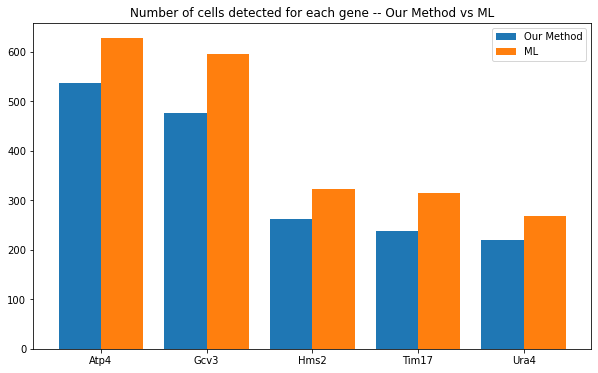

In [69]:
X = old_df['Gene'].unique()
  
X_axis = np.arange(len(X))
  
plt.figure(figsize=(10,6))
    
plt.bar(X_axis - 0.2, old_df['Gene'].value_counts(), 0.4, label = 'Our Method')
plt.bar(X_axis + 0.2, ml_df['Gene'].value_counts(), 0.4, label = 'ML')
  
plt.xticks(X_axis, X)
# plt.xlabel("Genes")
plt.title("Number of cells detected for each gene -- Our Method vs ML")
plt.legend()
plt.show()

### Quick look at total_rna stats

In [74]:
print("Our Method")
print(old_df['total_rna'].describe())
print("\nUsing ML")
print(ml_df['total_rna'].describe())

# Max rna decreased -- GOOD!

Our Method
count    1732.000000
mean       13.685912
std        21.902166
min         0.000000
25%         4.000000
50%         9.000000
75%        16.000000
max       355.000000
Name: total_rna, dtype: float64

Using ML
count    2126.000000
mean       12.913452
std        18.556294
min         0.000000
25%         4.000000
50%         9.000000
75%        16.000000
max       308.000000
Name: total_rna, dtype: float64


### Comparing total_rna correlation

In [88]:
print("Our Method")
print(old_df.corr()["total_rna"].sort_values(ascending=False)[:5])
print("\nML")
print(ml_df.corr()["total_rna"].sort_values(ascending=False)[:5])

print("\Our Method")
print(old_df.corr()["total_rna"].sort_values(ascending=False)[-5:])
print("\nML")
print(ml_df.corr()["total_rna"].sort_values(ascending=False)[-5:])

# No dramatic changes, fairly consistent results

Our Method
total_rna         1.000000
nb_rna_out_nuc    0.977628
nb_rna_in_nuc     0.865646
cell_area         0.231003
nuc_area          0.225811
Name: total_rna, dtype: float64

ML
total_rna           1.000000
nb_rna_out_nuc      0.986161
nb_rna_in_nuc       0.722535
index_dispersion    0.176452
cell_area           0.167061
Name: total_rna, dtype: float64
\Our Method
proportion_rna_cell_radius_500_1000   -0.049747
index_mean_distance_nuc               -0.062705
proportion_rna_protrusion             -0.075508
index_median_distance_nuc             -0.105673
index_polarization                    -0.231371
Name: total_rna, dtype: float64

ML
proportion_rna_cell_radius_500_1000    -0.027470
proportion_rna_cell_radius_1000_1500   -0.031249
proportion_rna_protrusion              -0.038196
index_median_distance_nuc              -0.055791
index_polarization                     -0.241944
Name: total_rna, dtype: float64


# Tests

### Tukey

In [108]:
def tukey(data):
    q1 = np.quantile(data,0.25)
    q3 = np.quantile(data,0.75)

    k = q3 + 1.5*(q3-q1)
    print("\nUpper bound: "+str(k))

    outliers = sum(data>k)
    print("No. of outliers: "+str(outliers))

In [94]:
atp_rna = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Atp4'].unique()

for d in dates:
    atp_rna.append(ml_df['total_rna'].loc[(ml_df['Gene'] == 'Atp4') & (ml_df['Date'] == d)])
    
    
    
gcv_rna = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Gcv3'].unique()

for d in dates:
    gcv_rna.append(ml_df['total_rna'].loc[(ml_df['Gene'] == 'Gcv3') & (ml_df['Date'] == d)])

    

hms_rna = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Hms2'].unique()

for d in dates:
    hms_rna.append(ml_df['total_rna'].loc[(ml_df['Gene'] == 'Hms2') & (ml_df['Date'] == d)])
    
    
    
tim_rna = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Tim17'].unique()

for d in dates:
    tim_rna.append(ml_df['total_rna'].loc[(ml_df['Gene'] == 'Tim17') & (ml_df['Date'] == d)])
    

    
ura_rna = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Ura4'].unique()

for d in dates:
    ura_rna.append(ml_df['total_rna'].loc[(ml_df['Gene'] == 'Ura4') & (ml_df['Date'] == d)])

    
    

all_rna = []
for g in ml_df['Gene'].unique():
    all_rna.append(ml_df['total_rna'].loc[(ml_df['Gene'] == g)])

In [109]:
for i in range(len(atp_rna)):
    tukey(atp_rna[i])


Upper bound: 30.5
No. of outliers: 7

Upper bound: 23.375
No. of outliers: 6

Upper bound: 32.5
No. of outliers: 2

Upper bound: 36.0
No. of outliers: 7


In [110]:
for i in range(len(gcv_rna)):
    tukey(gcv_rna[i])


Upper bound: 26.5
No. of outliers: 2

Upper bound: 18.0
No. of outliers: 4

Upper bound: 8.5
No. of outliers: 30

Upper bound: 62.375
No. of outliers: 10

Upper bound: 30.25
No. of outliers: 3


In [111]:
for i in range(len(hms_rna)):
    tukey(hms_rna[i])


Upper bound: 39.0
No. of outliers: 7

Upper bound: 50.0
No. of outliers: 2


In [112]:
for i in range(len(tim_rna)):
    tukey(tim_rna[i])


Upper bound: 14.0
No. of outliers: 8

Upper bound: 10.5
No. of outliers: 1

Upper bound: 13.0
No. of outliers: 0


In [113]:
for i in range(len(ura_rna)):
    tukey(ura_rna[i])


Upper bound: 37.5
No. of outliers: 10

Upper bound: 21.0
No. of outliers: 3


In [114]:
for i in range(len(all_rna)):
    tukey(all_rna[i])


Upper bound: 29.0
No. of outliers: 21

Upper bound: 18.25
No. of outliers: 61

Upper bound: 47.0
No. of outliers: 6

Upper bound: 15.5
No. of outliers: 6

Upper bound: 33.0
No. of outliers: 13


In [115]:
for i in range(len(all_rna)):
    print(len(remove_tukey(all_rna[i]))*100/len(all_rna[i]))
    
print(len(remove_tukey(ml_df['total_rna']))*100/len(ml_df['total_rna']))

95.7983193277311
90.27113237639553
97.77070063694268
98.13664596273291
94.40298507462687
95.48447789275635


In [120]:
atp_nuc = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Atp4'].unique()

for d in dates:
    atp_nuc.append(ml_df['nuc_area'].loc[(ml_df['Gene'] == 'Atp4') & (ml_df['Date'] == d)])
    
    
    
gcv_nuc = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Gcv3'].unique()

for d in dates:
    gcv_nuc.append(ml_df['nuc_area'].loc[(ml_df['Gene'] == 'Gcv3') & (ml_df['Date'] == d)])

    

hms_nuc = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Hms2'].unique()

for d in dates:
    hms_nuc.append(ml_df['nuc_area'].loc[(ml_df['Gene'] == 'Hms2') & (ml_df['Date'] == d)])
    
    
    
tim_nuc = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Tim17'].unique()

for d in dates:
    tim_nuc.append(ml_df['nuc_area'].loc[(ml_df['Gene'] == 'Tim17') & (ml_df['Date'] == d)])
    

    
ura_nuc = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Ura4'].unique()

for d in dates:
    ura_nuc.append(ml_df['nuc_area'].loc[(ml_df['Gene'] == 'Ura4') & (ml_df['Date'] == d)])
    
    

all_nuc = []
for g in ml_df['Gene'].unique():
    all_nuc.append(ml_df['nuc_area'].loc[(ml_df['Gene'] == g)])

In [121]:
for i in range(len(atp_nuc)):
    tukey(atp_nuc[i])


Upper bound: 1134.5
No. of outliers: 5

Upper bound: 1259.0
No. of outliers: 8

Upper bound: 1354.0
No. of outliers: 10

Upper bound: 1885.5
No. of outliers: 2


In [122]:
for i in range(len(gcv_nuc)):
    tukey(gcv_nuc[i])


Upper bound: 1467.75
No. of outliers: 5

Upper bound: 1583.5
No. of outliers: 14

Upper bound: 1063.25
No. of outliers: 28

Upper bound: 1566.75
No. of outliers: 3

Upper bound: 1721.75
No. of outliers: 2


In [123]:
for i in range(len(hms_nuc)):
    tukey(hms_nuc[i])


Upper bound: 1414.75
No. of outliers: 6

Upper bound: 1718.25
No. of outliers: 11


In [124]:
for i in range(len(tim_nuc)):
    tukey(tim_nuc[i])


Upper bound: 962.25
No. of outliers: 10

Upper bound: 1264.0
No. of outliers: 9

Upper bound: 1494.75
No. of outliers: 2


In [125]:
for i in range(len(ura_nuc)):
    tukey(ura_nuc[i])


Upper bound: 1040.25
No. of outliers: 9

Upper bound: 1390.5
No. of outliers: 8


In [126]:
for i in range(len(all_nuc)):
    tukey(all_nuc[i])


Upper bound: 1304.5
No. of outliers: 28

Upper bound: 1353.75
No. of outliers: 49

Upper bound: 1528.75
No. of outliers: 20

Upper bound: 1154.75
No. of outliers: 21

Upper bound: 1112.25
No. of outliers: 19


In [127]:
for i in range(len(all_nuc)):
    print(len(remove_tukey(all_nuc[i]))*100/len(all_nuc[i]))
    
print(len(remove_tukey(ml_df['nuc_area']))*100/len(ml_df['nuc_area']))

95.29411764705883
92.18500797448166
93.63057324840764
93.47826086956522
92.91044776119404
93.41486359360302


In [128]:
atp_cell = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Atp4'].unique()

for d in dates:
    atp_cell.append(ml_df['cell_area'].loc[(ml_df['Gene'] == 'Atp4') & (ml_df['Date'] == d)])
    
    
    
gcv_cell = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Gcv3'].unique()

for d in dates:
    gcv_cell.append(ml_df['cell_area'].loc[(ml_df['Gene'] == 'Gcv3') & (ml_df['Date'] == d)])

    

hms_cell = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Hms2'].unique()

for d in dates:
    hms_cell.append(ml_df['cell_area'].loc[(ml_df['Gene'] == 'Hms2') & (ml_df['Date'] == d)])
    
    
    
tim_cell = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Tim17'].unique()

for d in dates:
    tim_cell.append(ml_df['cell_area'].loc[(ml_df['Gene'] == 'Tim17') & (ml_df['Date'] == d)])
    

    
ura_cell = []
dates = ml_df['Date'].loc[ml_df['Gene'] == 'Ura4'].unique()

for d in dates:
    ura_cell.append(ml_df['cell_area'].loc[(ml_df['Gene'] == 'Ura4') & (ml_df['Date'] == d)])

    
    

all_cell = []
for g in ml_df['Gene'].unique():
    all_cell.append(ml_df['cell_area'].loc[(ml_df['Gene'] == g)])

In [129]:
for i in range(len(atp_cell)):
    tukey(atp_cell[i])


Upper bound: 14800.875
No. of outliers: 7

Upper bound: 18204.625
No. of outliers: 9

Upper bound: 15389.0
No. of outliers: 9

Upper bound: 15525.0
No. of outliers: 1


In [130]:
for i in range(len(gcv_cell)):
    tukey(gcv_cell[i])


Upper bound: 18141.75
No. of outliers: 0

Upper bound: 16539.5
No. of outliers: 12

Upper bound: 12360.75
No. of outliers: 8

Upper bound: 17475.25
No. of outliers: 6

Upper bound: 13050.375
No. of outliers: 1


In [131]:
for i in range(len(hms_cell)):
    tukey(hms_cell[i])


Upper bound: 16691.75
No. of outliers: 2

Upper bound: 13962.75
No. of outliers: 9


In [132]:
for i in range(len(tim_cell)):
    tukey(tim_cell[i])


Upper bound: 14140.5
No. of outliers: 8

Upper bound: 14662.5
No. of outliers: 1

Upper bound: 25163.25
No. of outliers: 1


In [133]:
for i in range(len(ura_cell)):
    tukey(ura_cell[i])


Upper bound: 15403.0
No. of outliers: 5

Upper bound: 18650.5
No. of outliers: 2


In [134]:
for i in range(len(all_cell)):
    tukey(all_cell[i])


Upper bound: 16467.25
No. of outliers: 25

Upper bound: 14588.75
No. of outliers: 28

Upper bound: 15702.375
No. of outliers: 7

Upper bound: 15421.25
No. of outliers: 16

Upper bound: 16718.25
No. of outliers: 7


In [135]:
for i in range(len(all_cell)):
    print(len(remove_tukey(all_cell[i]))*100/len(all_cell[i]))
    
print(len(remove_tukey(ml_df['cell_area']))*100/len(ml_df['cell_area']))

95.7983193277311
95.53429027113238
97.77070063694268
95.03105590062111
97.38805970149254
95.86077140169333


### Kolmogorov–Smirnov test

In [79]:
def remove_tukey(data):
    q1 = np.quantile(data,0.25)
    q3 = np.quantile(data,0.75)
    k = q3 + 1.5*(q3-q1)
    return data[data<k]

In [80]:
def kstest_total_rna(df, gene, c=0):  # c = 1 means use remove_tukey()
    gene_rna = []
    dates = df['Date'].loc[df['Gene'] == gene].unique()
    for d in dates:
        gene_rna.append(df['total_rna'].loc[(df['Gene'] == gene) & (df['Date'] == d)])
    
    if c==0:
        for d in gene_rna:                     
            print("p-value: "+str(stats.kstest(d, 'poisson', args=(d.mean(),0))[1]))
    
    if c==1:
        for d in gene_rna:                     
            print("p-value: "+str(stats.kstest(remove_tukey(d), 'poisson', args=(remove_tukey(d).mean(),0))[1]))

In [90]:
for g in old_df['Gene'].unique():
    print("\n------------ "+g+" ------------")
    print("Our Method")
    kstest_total_rna(old_df, g,1)
    print("\nML")
    kstest_total_rna(ml_df, g,1)


------------ Atp4 ------------
Our Method
p-value: 0.03836931837952497
p-value: 0.0018093909977500964
p-value: 0.0008027516584263104
p-value: 0.0016419701345666837

ML
p-value: 0.034007059587847756
p-value: 0.00013043068938703927
p-value: 3.639266798706125e-05
p-value: 8.81263633944417e-05

------------ Gcv3 ------------
Our Method
p-value: 0.0011994918866455873
p-value: 1.5422957095493613e-06
p-value: 1.7795859818400984e-06
p-value: 1.2394193779903959e-12
p-value: 0.8655702186854807

ML
p-value: 0.0018429981021128583
p-value: 3.6169848884497914e-07
p-value: 1.5288170453160157e-09
p-value: 0.023060925787421804
p-value: 0.29767713974052523

------------ Hms2 ------------
Our Method
p-value: 4.3370311744006623e-07
p-value: 3.5288733450155806e-05

ML
p-value: 7.827301568449183e-08
p-value: 1.8937751351513353e-08

------------ Tim17 ------------
Our Method
p-value: 0.0065044664386295645
p-value: 0.00076466256861033
p-value: 0.04374840421390758

ML
p-value: 0.001582578289298179
p-value: 0.

In [91]:
def kstest_all(df, c=0):
    all_genes = []

    for g in df['Gene'].unique():
        all_genes.append(df['total_rna'].loc[(df['Gene'] == g)])
    
    if c==0:
        for d in all_genes:
            print("p-value: "+str(stats.kstest(d, 'poisson', args=(d.mean(),0))[1]))
            
    if c==1:
        for d in all_genes:
            print("p-value: "+str(stats.kstest(remove_tukey(d), 'poisson', args=(remove_tukey(d).mean(),0))[1]))

In [92]:
print("Original")
kstest_all(old_df,1)
print("\nML")
kstest_all(ml_df,1)

Original
p-value: 3.9064598220104977e-10
p-value: 4.535587205657054e-26
p-value: 4.752461513237091e-12
p-value: 2.60959575839909e-07
p-value: 1.8752376841323546e-06

ML
p-value: 7.666243918955972e-15
p-value: 1.1103148241640712e-27
p-value: 1.3197902581231714e-14
p-value: 1.2421641753880165e-05
p-value: 8.176586052563174e-07


### Mann–Whitney U test

In [84]:
def MWU_total_rna(df, gene, c=0):
    gene_rna = []
    dates = df['Date'].loc[df['Gene'] == gene].unique()
    for d in dates:
        gene_rna.append(df['total_rna'].loc[(df['Gene'] == gene) & (df['Date'] == d)])
    
    if c==0:
        for i in range(len(gene_rna)):
            for j in range(len(gene_rna)):
                if(j>i):
                    U1, p = mannwhitneyu(gene_rna[i], gene_rna[j])
                    print(dates[i],dates[j],"\t",p)

    if c==1:
        for i in range(len(gene_rna)):
            for j in range(len(gene_rna)):
                if(j>i):
                    U1, p = mannwhitneyu(remove_tukey(gene_rna[i]), remove_tukey(gene_rna[j]))
                    print(dates[i],dates[j],"\t",p)

In [85]:
for g in old_df['Gene'].unique():
    print("\n------------ "+g+" ------------")
    print("\nOriginal")
    MWU_total_rna(old_df, g)
    print("\nML")
    MWU_total_rna(ml_df, g)


------------ Atp4 ------------

Original
20april 30June 	 1.2175155524965755e-10
20april 30May 	 0.7352441628321893
20april 31May 	 0.005075336596562605
30June 30May 	 5.249786190055906e-10
30June 31May 	 0.665030521237749
30May 31May 	 0.008232210817441663

ML
20april 30June 	 2.0283111068460873e-12
20april 30May 	 0.2792497496603634
20april 31May 	 0.020248991234334292
30June 30May 	 2.353422964171786e-10
30June 31May 	 0.09886401011241046
30May 31May 	 0.09793699604055006

------------ Gcv3 ------------

Original
20april 30June 	 2.7198283702896267e-10
20april 30May02 	 2.6711841523156842e-14
20april 31May 	 0.05382505665353707
20april 31May12 	 0.03233879992631514
30June 30May02 	 2.1374797987279213e-14
30June 31May 	 1.1309569192090316e-15
30June 31May12 	 0.1335297784476439
30May02 31May 	 8.424423169271968e-17
30May02 31May12 	 0.00011445162607538291
31May 31May12 	 0.0006159950006554939

ML
20april 30June 	 0.03278150315717753
20april 30May02 	 7.810994001212107e-09
20april 31

In [86]:
def MWU_all(df, c = 0):
    
    all_genes = []

    for g in df['Gene'].unique():
        all_genes.append(df['total_rna'].loc[(df['Gene'] == g)])
    names = df['Gene'].unique()

    if c==0:
        for i in range(len(all_genes)):
            for j in range(len(all_genes)):
                if(j>i):
                    U1, p = mannwhitneyu(all_genes[i], all_genes[j])
                    print(names[i],names[j],"\t",p)
                    
    if c==1:
        for i in range(len(all_genes)):
            for j in range(len(all_genes)):
                if(j>i):
                    U1, p = mannwhitneyu(remove_tukey(all_genes[i]), remove_tukey(all_genes[j]))
                    print(names[i],names[j],"\t",p)

In [87]:
print("Original")
MWU_all(old_df)
print("\nML")
MWU_all(ml_df)

Original
Atp4 Gcv3 	 6.45770923166623e-47
Atp4 Hms2 	 2.0763939277630748e-10
Atp4 Tim17 	 1.7608860544959522e-56
Atp4 Ura4 	 0.22023564591570033
Gcv3 Hms2 	 2.035984120758038e-43
Gcv3 Tim17 	 0.20756211078562592
Gcv3 Ura4 	 2.367381893955027e-26
Hms2 Tim17 	 2.5004651194189302e-54
Hms2 Ura4 	 2.6306279506838726e-09
Tim17 Ura4 	 7.960870105051606e-36

ML
Atp4 Gcv3 	 1.2665211285217459e-70
Atp4 Hms2 	 4.577900010282694e-17
Atp4 Tim17 	 3.056031835001097e-68
Atp4 Ura4 	 0.7523461438354084
Gcv3 Hms2 	 3.787140228887127e-68
Gcv3 Tim17 	 0.0003588536054122731
Gcv3 Ura4 	 2.0079717887463024e-43
Hms2 Tim17 	 4.463982392989334e-71
Hms2 Ura4 	 3.354071388074263e-11
Tim17 Ura4 	 6.316719637850227e-47
